In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, f1_score

# Data Cleaning

In [4]:
df = pd.read_csv('./dataset/train_data.txt', sep=":::", names=["Title", "Genre", "Description"], engine="python")
test_data = pd.read_csv('./dataset/train_data.txt', sep=":::", names=["Id" ,"Title", "Description"], engine="python")

In [5]:
df

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [6]:
df.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [7]:
df.shape

(54214, 3)

In [8]:
df.describe()

,Title,Genre,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [9]:
df.isnull().sum()

Title          0
Genre          0
Description    0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [11]:
test_data

,Id,Title,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [12]:
test_data.shape

(54214, 3)

In [13]:
test_data.head()

,Id,Title,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [14]:
test_data.describe()

,Id,Title,Description
count,54214,54214,54214
unique,54214,27,54086
top,Oscar et la dame rose (2009),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [15]:
test_data.isnull().sum()

Id             0
Title          0
Description    0
dtype: int64

In [16]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Id           54214 non-null  object
 1   Title        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


# Data Preprocessing

In [17]:
# Ensure the stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def data_processing(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'.pic\S+', '', text)
    text = re.sub(r'[^a-zA-Z+]', ' ', text)  # Change to replace non-characters with a space
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    # Use the predefined stop_words variable instead of redefining it inside the function
    text = " ".join([i for i in words if i not in stop_words and len(i) > 2])
    text = re.sub(r"\s+", " ", text).strip()  # Replace multiple spaces with a single space
    return text

df["TextCleaning"] = df["Description"].apply(data_processing)
test_data["TextCleaning"] = test_data["Description"].apply(data_processing)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
df.head()

,Title,Genre,Description,TextCleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film title refers recovered bodies ground zero...


In [19]:
test_data.head()

,Id,Title,Description,TextCleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film title refers recovered bodies ground zero...


# EDA

C:\Users\priya\AppData\Local\Temp\ipykernel_117928\681862621.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, palette='flare')


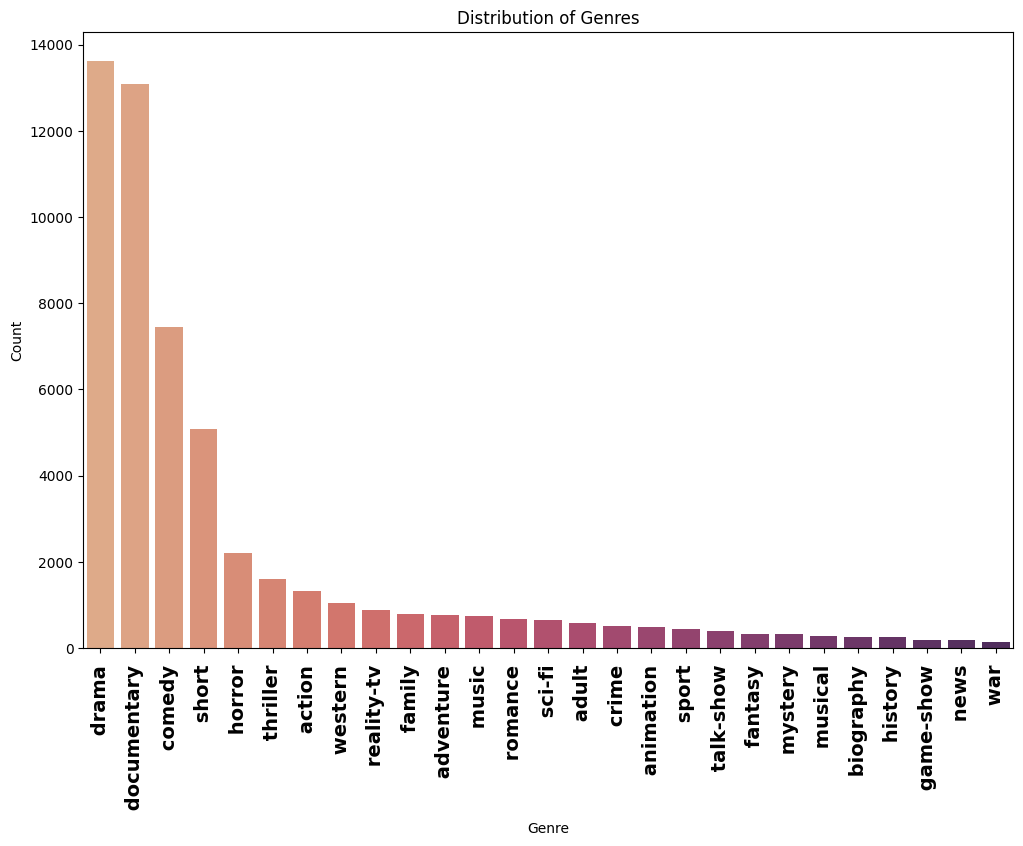

In [20]:
plt.figure(figsize=(12,8))
counts = df.Genre.value_counts()
sns.barplot(x=counts.index, y=counts, palette='flare')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Distribution of Genres')
plt.xticks(rotation=90, fontsize=14, fontweight='bold');

C:\Users\priya\AppData\Local\Temp\ipykernel_117928\408498915.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y="Genre", order= df["Genre"].value_counts().index, palette='viridis', legend=False)


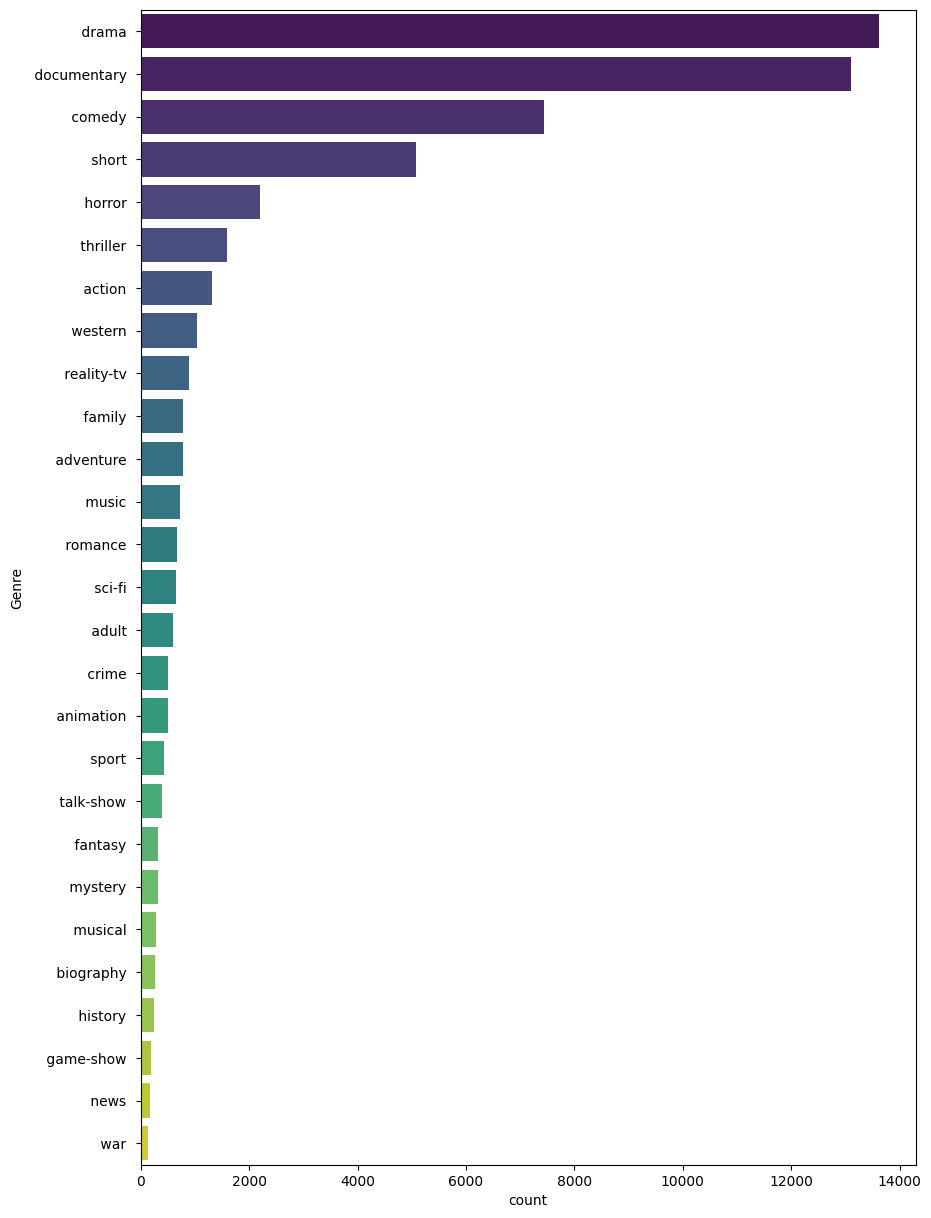

In [21]:
plt.figure(figsize=(10,15))
sns.countplot(data=df, y="Genre", order= df["Genre"].value_counts().index, palette='viridis', legend=False)
plt.show()

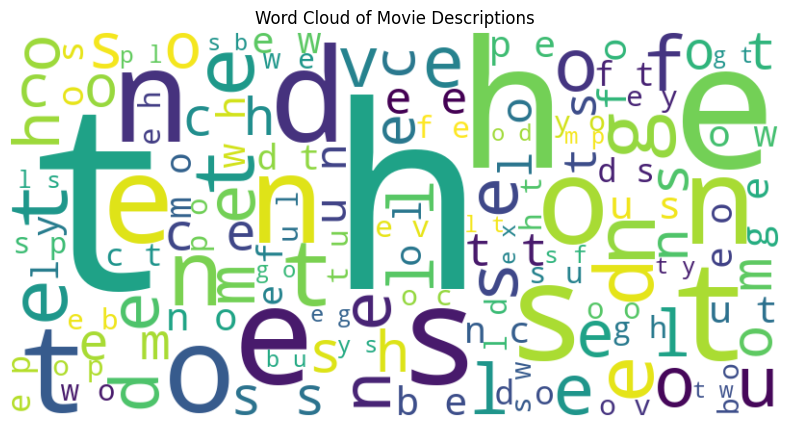

In [22]:
from wordcloud import WordCloud

# Combine all descriptions into a single text
all_descriptions = ' '.join([' '.join(desc) for desc in df['Description']])

# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(all_descriptions)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Descriptions')
plt.show()

## Using TF-IDF to vectorize the data

In [23]:
vector = TfidfVectorizer()

x_train = vector.fit_transform(df["TextCleaning"])
x_test = vector.transform(test_data["TextCleaning"])

# Making Models

## Splitting the data into train data and test data

In [24]:
x = x_train
y = df["Genre"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=42)

In [25]:
print("Size of x_train: ", (x_train.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of x_test: ", (x_test.shape))
print("Size of y_test: ", (y_test.shape))

Size of x_train:  (43371, 116601)
Size of y_train:  (43371,)
Size of x_test:  (10843, 116601)
Size of y_test:  (10843,)


## Training The Models


In [26]:
columns=['MultinomialNB','LogisticRegression','SVC']
result=[]

### MultinomialNB (Naive Bayes)

In [27]:
modelNB = MultinomialNB()
modelNB.fit(x_train, y_train)
y_pred = modelNB.predict(x_test)

accuracy = accuracy_score(y_pred,y_test)
result.append(accuracy)
    
print("-----Model Evaluation on Test Data-----")
print(modelNB)
print(accuracy)

-----Model Evaluation on Test Data-----
MultinomialNB()
0.4460942543576501


### Logistic Regression

In [28]:
modelLR = LogisticRegression(max_iter=55000)
modelLR.fit(x_train, y_train)
y_pred = modelLR.predict(x_test)

accuracy = accuracy_score(y_pred,y_test)
result.append(accuracy)
    
print("-----Model Evaluation on Test Data-----")
print(modelLR)
print(accuracy)

-----Model Evaluation on Test Data-----
LogisticRegression(max_iter=55000)
0.5784377017430601


### Support Vector Machine

In [29]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

modelSVC = SVC(kernel='linear')
modelSVC.fit(x_train, y_train)
y_pred = modelSVC.predict(x_test)

accuracy = accuracy_score(y_pred, y_test)
result.append(accuracy)

print("-----Model Evaluation on Test Data-----")
print(modelSVC)
print("Accuracy:", accuracy)


-----Model Evaluation on Test Data-----
SVC(kernel='linear')
Accuracy: 0.5973439085124043


# Comparing Results

In [30]:
FinalResult=pd.DataFrame({'Model':columns, 'Accuracy':result})
FinalResult

,Model,Accuracy
0,MultinomialNB,0.446094
1,LogisticRegression,0.578438
2,SVC,0.597344


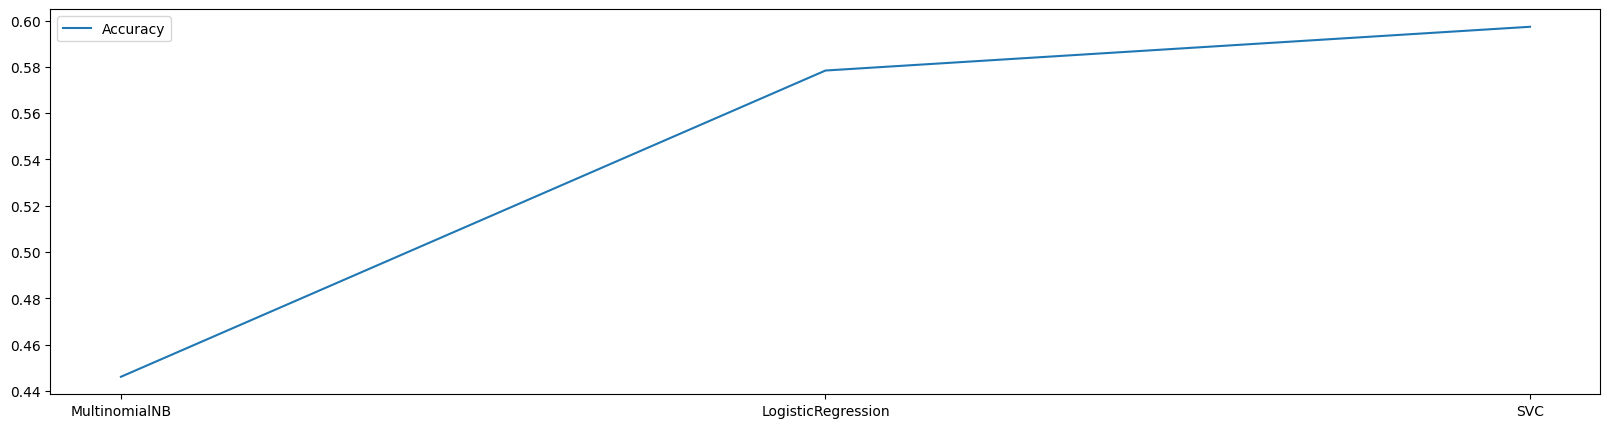

In [31]:
fig,ax=plt.subplots(figsize=(20,5))
plt.plot(FinalResult.Model,result,label="Accuracy")
plt.legend()
plt.show()

## Confusion Matrices

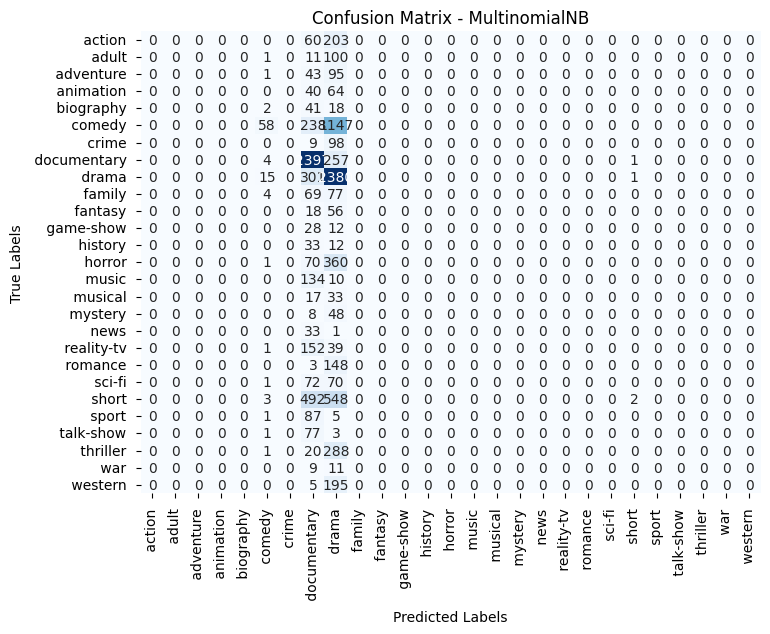

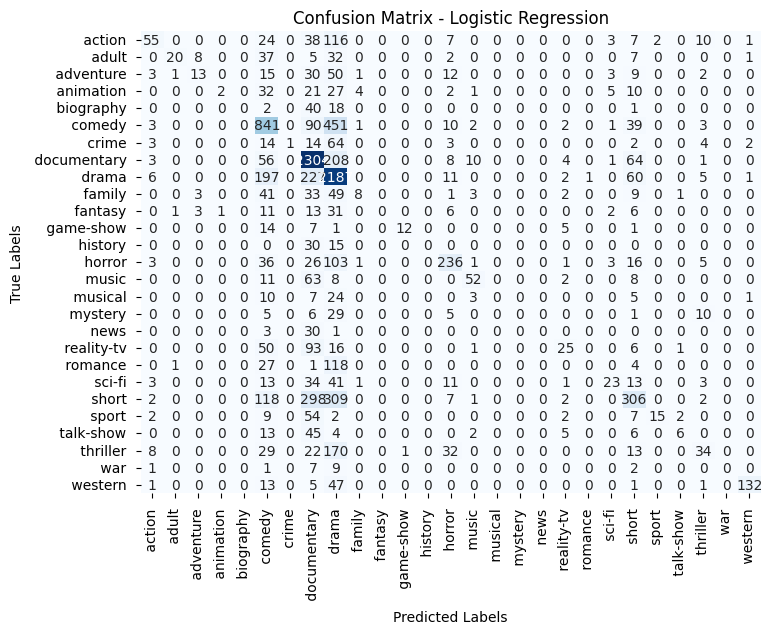

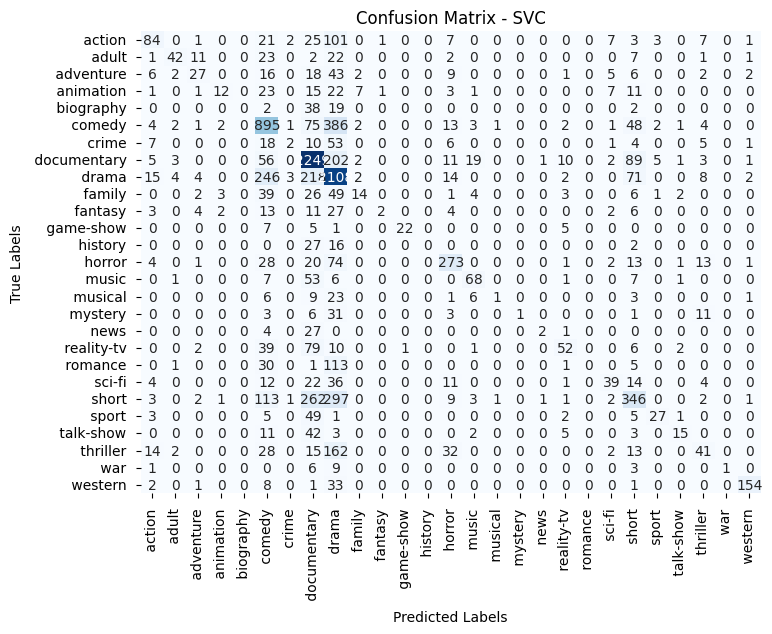

In [35]:
def plot_confusion_matrix(model, x_test, y_test, title):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(modelNB, x_test, y_test, 'Confusion Matrix - MultinomialNB')
plot_confusion_matrix(modelLR, x_test, y_test, 'Confusion Matrix - Logistic Regression')
plot_confusion_matrix(modelSVC, x_test, y_test, 'Confusion Matrix - SVC')